=== Pre-computing rotation arrays ===
NSIDE=4, pixels=192
Rotation angles: theta=60°, phi=60°
  Conflict positions: 28
  Holes: 28
  Unique mappings after fix: 192/192
Array computation completed!
rot_arr range: 0 - 191
rerot_arr range: 0 - 191


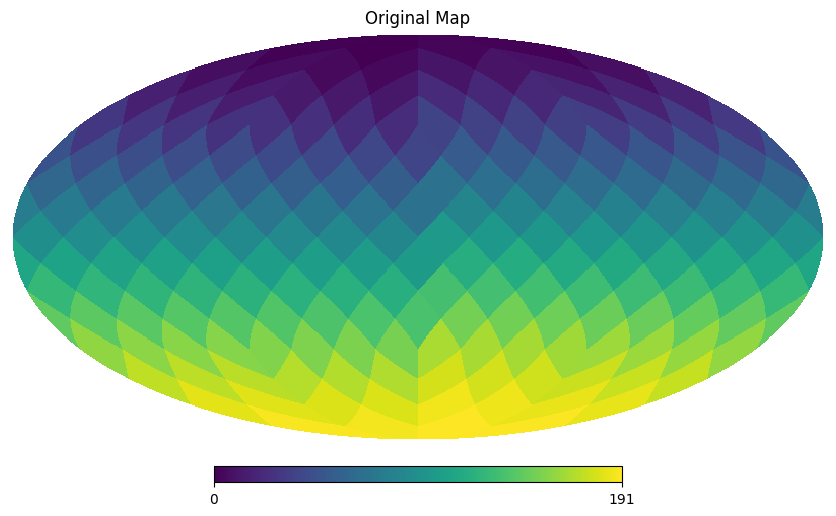

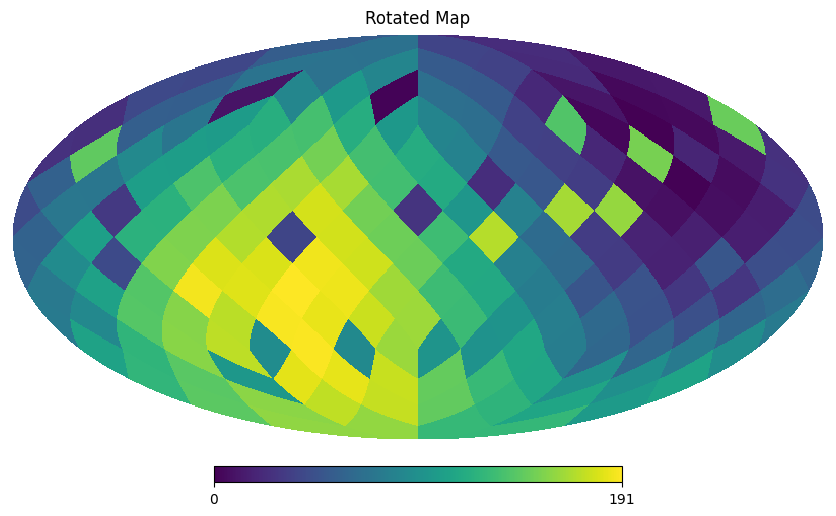

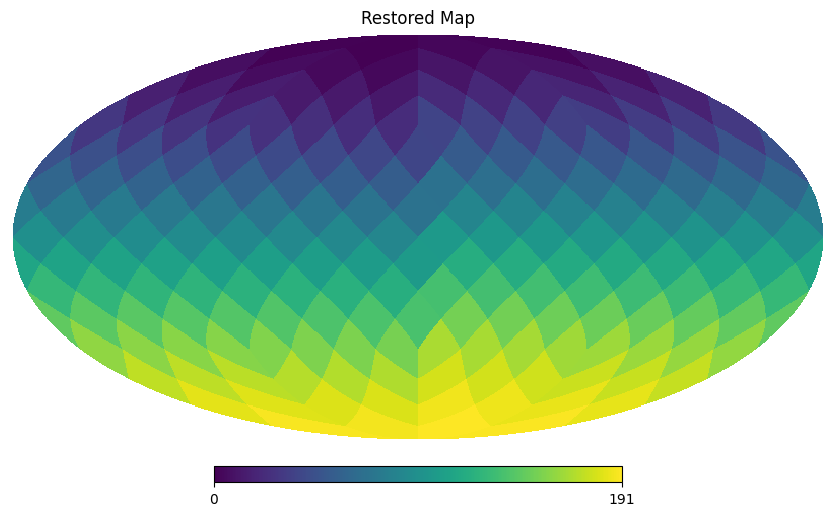

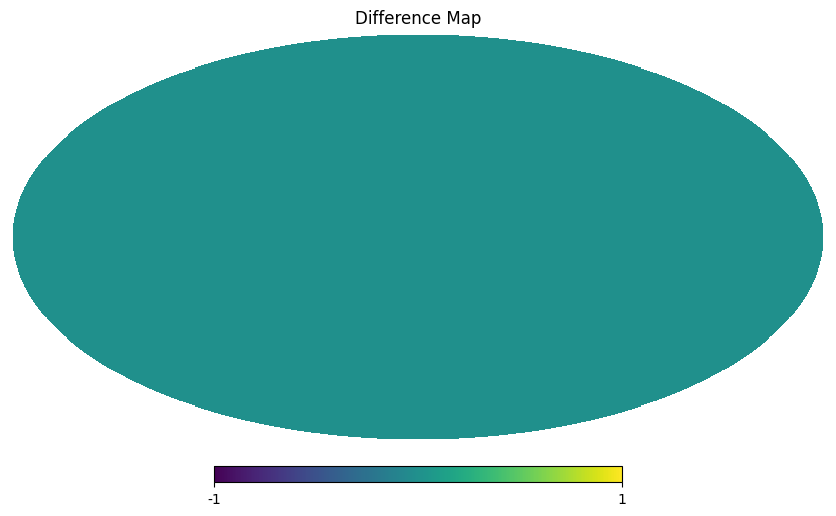

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
HEALPix Redistribution Rotation Code
Easy to use, solves pixel loss problem
"""

import numpy as np
import healpy as hp

def healpix_rotate_perfect(original_map, theta_deg, phi_deg):
    """
    Perfect HEALPix rotation function - no pixel loss, perfect recovery
    
    Parameters:
    original_map: Your original sky map (e.g.: np.arange(hp.nside2npix(128)))
    theta_deg: theta rotation angle (degrees)
    phi_deg: phi rotation angle (degrees)
    
    Returns:
    rotated_map: Rotated sky map
    restore_function: Restore function, call it to perfectly recover original map
    """
    
    nside = hp.npix2nside(len(original_map))
    npix = len(original_map)
    
    print(f"Executing redistribution rotation: NSIDE={nside}, pixels={npix}")
    print(f"Rotation angles: theta={theta_deg}°, phi={phi_deg}°")
    
    # Step 1: Create rotator
    rotator = hp.Rotator(rot=[phi_deg, theta_deg], deg=True)
    
    # Step 2: Get angular coordinates of all pixels
    ipix_all = np.arange(npix)
    angles = hp.pix2ang(nside, ipix_all)
    theta_all = angles[0]
    phi_all = angles[1]
    
    # Step 3: Calculate rotated angles
    rot_result = rotator(theta_all, phi_all)
    theta_rot = rot_result[0]
    phi_rot = rot_result[1]
    
    # Step 4: Find corresponding pixel indices after rotation
    forward_map_raw = hp.ang2pix(nside, theta_rot, phi_rot)
    
    # Step 5: Redistribution to solve conflicts (this is the key step!)
    forward_map_fixed = _fix_mapping_conflicts(forward_map_raw, npix)
    
    # Step 6: Apply rotation
    rotated_map = np.zeros_like(original_map)
    rotated_map[forward_map_fixed] = original_map
    
    # Step 7: Create restore function
    def restore_function():
        """Restore to original sky map"""
        restored_map = rotated_map[forward_map_fixed]
        return restored_map
    
    print("Rotation completed! No pixel loss.")
    
    return rotated_map, restore_function

def _fix_mapping_conflicts(forward_map_raw, npix):
    """
    Core function to fix mapping conflicts
    """
    
    # Count how many source pixels map to each target position
    target_sources = {}
    for source, target in enumerate(forward_map_raw):
        if target not in target_sources:
            target_sources[target] = []
        target_sources[target].append(source)
    
    # Find conflicts (multiple sources map to same target) and holes (no sources map to target)
    conflicts = {t: sources for t, sources in target_sources.items() if len(sources) > 1}
    occupied = set(forward_map_raw)
    holes = list(set(range(npix)) - occupied)
    
    print(f"  Conflict positions: {len(conflicts)}")
    print(f"  Holes: {len(holes)}")
    
    # Fix mapping
    forward_map_fixed = forward_map_raw.copy()
    hole_idx = 0
    
    for target, sources in conflicts.items():
        # Keep first source mapping, reassign others to holes
        for source in sources[1:]:
            if hole_idx < len(holes):
                forward_map_fixed[source] = holes[hole_idx]
                hole_idx += 1
            else:
                # If not enough holes (rare case), keep original position
                forward_map_fixed[source] = source
    
    # Verify fix results
    unique_after = len(set(forward_map_fixed))
    print(f"  Unique mappings after fix: {unique_after}/{npix}")
    
    return forward_map_fixed

def compute_rotation_arrays(nside, theta_deg, phi_deg):
    """
    Pre-compute rotation and restore sorting arrays for efficient batch rotation of multiple sky maps
    
    Parameters:
    nside: HEALPix NSIDE parameter
    theta_deg: theta rotation angle (degrees)
    phi_deg: phi rotation angle (degrees)
    
    Returns:
    rot_arr: Rotation sorting array, usage: rot_map = original_map[rot_arr]
    rerot_arr: Restore sorting array, usage: rerot_map = rot_map[rerot_arr]
    """
    
    npix = hp.nside2npix(nside)
    
    print(f"=== Pre-computing rotation arrays ===")
    print(f"NSIDE={nside}, pixels={npix}")
    print(f"Rotation angles: theta={theta_deg}°, phi={phi_deg}°")
    
    # Step 1: Create rotator
    rotator = hp.Rotator(rot=[phi_deg, theta_deg], deg=True)
    
    # Step 2: Get angular coordinates of all pixels
    ipix_all = np.arange(npix)
    angles = hp.pix2ang(nside, ipix_all)
    theta_all = angles[0]
    phi_all = angles[1]
    
    # Step 3: Calculate rotated angles
    rot_result = rotator(theta_all, phi_all)
    theta_rot = rot_result[0]
    phi_rot = rot_result[1]
    
    # Step 4: Find corresponding pixel indices after rotation
    forward_map_raw = hp.ang2pix(nside, theta_rot, phi_rot)
    
    # Step 5: Redistribution to solve conflicts
    forward_map_fixed = _fix_mapping_conflicts(forward_map_raw, npix)
    
    # Step 6: Calculate rotation array
    # rot_arr[i] indicates where the i-th pixel of original map goes in rotated map
    rot_arr = forward_map_fixed
    
    # Step 7: Calculate restore array
    # rerot_arr[i] indicates which pixel in original map corresponds to i-th pixel in rotated map
    rerot_arr = np.zeros(npix, dtype=int)
    for orig_idx, rot_idx in enumerate(rot_arr):
        rerot_arr[rot_idx] = orig_idx
    
    print(f"Array computation completed!")
    print(f"rot_arr range: {rot_arr.min()} - {rot_arr.max()}")
    print(f"rerot_arr range: {rerot_arr.min()} - {rerot_arr.max()}")
    
    return rot_arr, rerot_arr

def batch_rotate_maps(maps_list, rot_arr):
    """
    Batch rotate multiple sky maps
    
    Parameters:
    maps_list: List of sky maps, each element is a sky map array
    rot_arr: Pre-computed rotation sorting array
    
    Returns:
    rotated_maps: List of rotated sky maps
    """
    
    print(f"Batch rotating {len(maps_list)} sky maps...")
    
    rotated_maps = []
    for i, original_map in enumerate(maps_list):
        # Simple array indexing operation for rotation
        rot_map = original_map[rot_arr]
        rotated_maps.append(rot_map)
        
        if (i + 1) % 10 == 0 or (i + 1) == len(maps_list):
            print(f"  Completed: {i + 1}/{len(maps_list)}")
    
    print("Batch rotation completed!")
    return rotated_maps

def batch_restore_maps(rotated_maps_list, rerot_arr):
    """
    Batch restore multiple sky maps
    
    Parameters:
    rotated_maps_list: List of rotated sky maps
    rerot_arr: Pre-computed restore sorting array
    
    Returns:
    restored_maps: List of restored sky maps
    """
    
    print(f"Batch restoring {len(rotated_maps_list)} sky maps...")
    
    restored_maps = []
    for i, rot_map in enumerate(rotated_maps_list):
        # Simple array indexing operation for restoration
        rerot_map = rot_map[rerot_arr]
        restored_maps.append(rerot_map)
        
        if (i + 1) % 10 == 0 or (i + 1) == len(rotated_maps_list):
            print(f"  Completed: {i + 1}/{len(rotated_maps_list)}")
    
    print("Batch restoration completed!")
    return restored_maps

# ============================================================================
# Usage Examples
# ============================================================================

if __name__ == "__main__":
    
    nside = 4
    for theta_batch in [60]:
        for phi_batch in [60]:
            rot_arr, rerot_arr = compute_rotation_arrays(nside, theta_batch, phi_batch)
            
    mmap = np.arange(hp.nside2npix(nside))
    rot_map = mmap[rot_arr]
    rerot_map = rot_map[rerot_arr]

    hp.mollview(mmap, title='Original Map')
    hp.mollview(rot_map, title='Rotated Map')
    hp.mollview(rerot_map, title='Restored Map')

    hp.mollview(rerot_map-mmap, title='Difference Map')
   